In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

from utils import subdivide_bbox

In [2]:
# ee.Authenticate() # comentar
ee.Initialize()

In [3]:
min_lon, min_lat = -70.95, -33.65
max_lon, max_lat = -70.445, -33.325

santiago_bbox = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])
emb_col = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
emb_2024 = emb_col.filterDate('2024-01-01', '2025-01-01').mosaic()

In [4]:
min_lon, min_lat = -70.95, -33.65
max_lon, max_lat = -70.445, -33.325

mid_lon = (min_lon + max_lon) / 2.0
mid_lat = (min_lat + max_lat) / 2.0

boxes = subdivide_bbox(-70.95, -33.65, -70.445, -33.325, depth=2)

emb_col = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
emb_2024 = emb_col.filterDate('2024-01-01', '2025-01-01').mosaic()

def sample_box(geom, n_samples):
    fc = emb_2024.sample(
        region=geom,
        scale=10,
        numPixels=n_samples,
        geometries=True
    )
    fc_dict = fc.getInfo()
    rows = []
    for feat in fc_dict["features"]:
        props = dict(feat["properties"])
        lon, lat = feat["geometry"]["coordinates"]
        props["lon"] = lon
        props["lat"] = lat
        rows.append(props)
    return rows

all_rows = []
for geom in boxes:
    all_rows.extend(sample_box(geom, n_samples=5000))  # 4 * 5000 = ~20000

# 4. Pasar a GeoDataFrame
gdf = gpd.GeoDataFrame(
    all_rows,
    geometry=[Point(r["lon"], r["lat"]) for r in all_rows],
    crs="EPSG:4326"
)

# 5. (opcional) reproyección métrica
gdf_3857 = gdf.to_crs(epsg=3857)

# 6. Guardar local
gdf.to_file("../data/embeddings_alpha_earth.gpkg", driver="GPKG")

In [5]:
comunas = gpd.read_file("../data/comunas_filtradas.gpkg")

gdf_subset = gpd.sjoin(
    gdf_3857,
    comunas[["Comuna", "geometry"]],
    how="inner",
    predicate="within"
)

gdf_subset = gdf_subset.drop(columns=["index_right"], errors="ignore")
gdf_subset.to_file("../data/embeddings_alpha_earth.gpkg", driver="GPKG")
print(gdf_subset.shape)

(62343, 68)


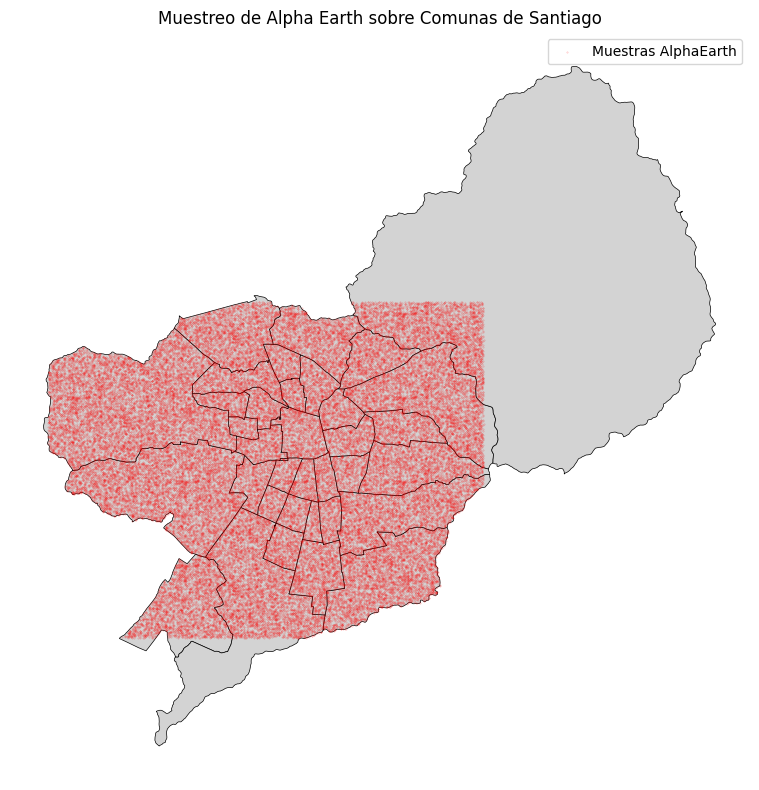

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
comunas.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)
ax.scatter(
    gdf_subset.geometry.x,
    gdf_subset.geometry.y,
    s=.1,
    alpha=0.3,
    color="red",
    label="Muestras AlphaEarth"
)

ax.set_title("Muestreo de Alpha Earth sobre Comunas de Santiago", fontsize=12)
ax.set_axis_off()
plt.legend()
plt.tight_layout()
plt.show()
